Data Snapshot & Pipeline


In [21]:
# --- Data Snapshot & Pipeline (no ace_tools) ---------------------------
# Place this cell at the top of your EDA.ipynb notebook.
# It loads the CSV, prints basic info, and displays quick tables.

import pandas as pd
from IPython.display import display  # native Jupyter helper

CSV_PATH = "/Users/shuqizhao/Desktop/Biticoin Project/raw_sample_2023_07.csv"  # update if your file is elsewhere
df = pd.read_csv(CSV_PATH)

# 1) Basic file information
print("🗂️ File:", CSV_PATH)
print("🔢 Rows:", len(df), "| Columns:", len(df.columns))

# 2) Preview the first five rows
print("\n▼ Head (first 5 rows)")
display(df.head())

# 3) Column-level overview
summary = (
    pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "non_null": df.notnull().sum(),
        "unique": df.nunique(dropna=True),
        "example_value": [
            df[col].dropna().iloc[0] if df[col].notna().any() else None
            for col in df.columns
        ],
    })
    .reset_index(names="column")
)

print("\n▼ Column Summary")
display(summary)

# 4) Optional: parse timestamp and set index for time-series workflows
# df["Timestamp"] = pd.to_datetime(df["Timestamp"])
# df = df.set_index("Timestamp").sort_index()

🗂️ File: /Users/shuqizhao/Desktop/Biticoin Project/raw_sample_2023_07.csv
🔢 Rows: 36111 | Columns: 9

▼ Head (first 5 rows)


,Unnamed: 0.1,Unnamed: 0,Timestamp,Open,High,Low,Close,Volume,Avg_price
0,1675787,1675787,2023-07-01 00:00:00,30407.1,30418.2,30407.1,30416.9,0.000027,30412.65
1,1675788,1675788,2023-07-01 00:01:00,30416.9,30416.9,30392.3,30393.2,0.000016,30404.60
2,1675789,1675789,2023-07-01 00:02:00,30393.5,30417.3,30393.5,30402.2,0.000074,30405.40
3,1675790,1675790,2023-07-01 00:03:00,30404.1,30420.8,30404.1,30413.4,0.000056,30412.45
4,1675791,1675791,2023-07-01 00:04:00,30413.6,30427.2,30413.4,30422.8,0.000039,30420.30



▼ Column Summary


,column,dtype,non_null,unique,example_value
0,Unnamed: 0.1,int64,36111,36111,1675787
1,Unnamed: 0,int64,36111,36111,1675787
2,Timestamp,object,36111,36111,2023-07-01 00:00:00
3,Open,float64,36111,15417,30407.1
4,High,float64,36111,14576,30418.2
5,Low,float64,36111,15211,30407.1
6,Close,float64,36111,15251,30416.9
7,Volume,float64,36111,8130,0.000027
8,Avg_price,float64,36111,23769,30412.65


Missing-Timestamp Analysis

Expected minutes : 44,628
Actual rows      : 36,111
Missing minutes  : 8,517  (19.1% missing)


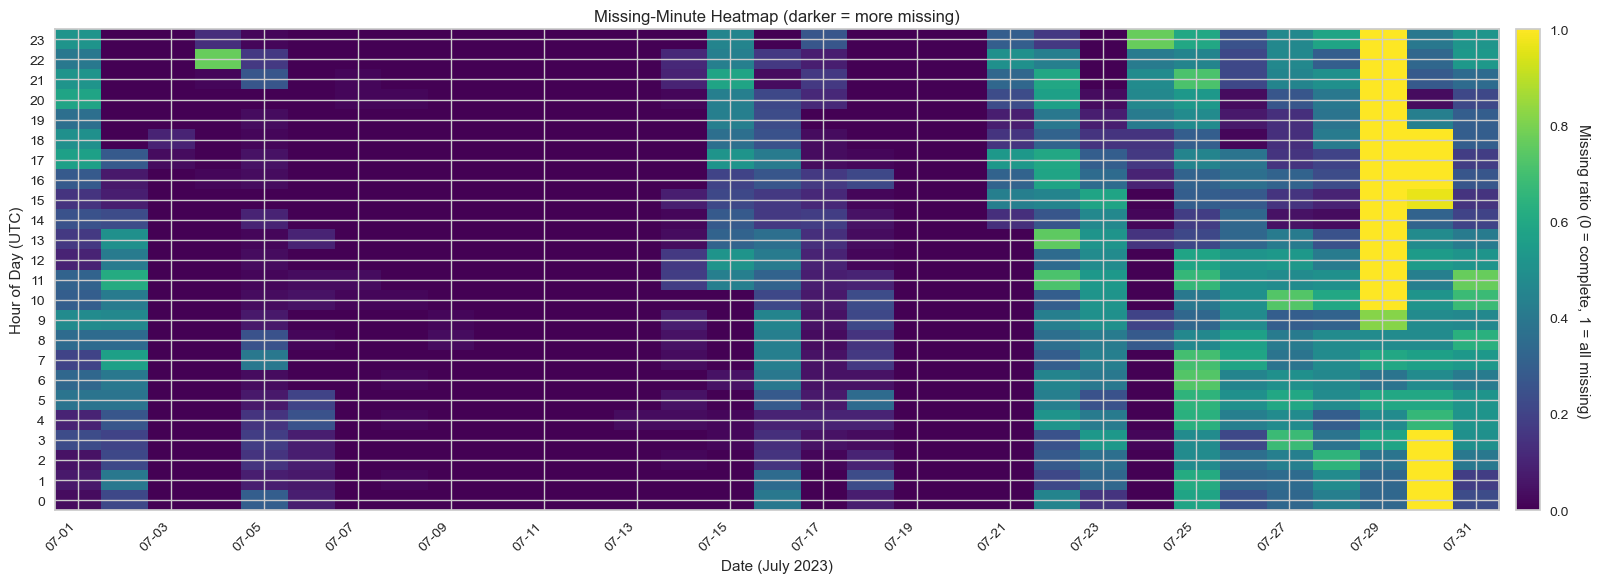


Top 3 longest gaps (minutes):


,first,last,size
3151,2023-07-29 09:23:00,2023-07-30 04:01:00,1119
3335,2023-07-30 15:02:00,2023-07-30 19:00:00,239
475,2023-07-04 22:00:00,2023-07-04 22:34:00,35


In [23]:
# --- Missing-Timestamp Analysis ---------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# 0) basic cleanup ------------------------------------------------------
#    (skip if you already did this in a previous cell)
df = df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.set_index("Timestamp").sort_index()

# 1) Build a full minute index -----------------------------------------
full_idx = pd.date_range(start=df.index.min().floor("min"),
                         end=df.index.max().ceil("min"),
                         freq="1min")

# 2) Identify missing minutes ------------------------------------------
missing = full_idx.difference(df.index)

print(f"Expected minutes : {len(full_idx):,}")
print(f"Actual rows      : {len(df):,}")
print(f"Missing minutes  : {len(missing):,}  "
      f"({len(missing)/len(full_idx):.1%} missing)")

# 3) Prepare presence matrix for the heatmap ---------------------------
presence = pd.Series(1, index=df.index).reindex(full_idx, fill_value=0)
presence_df = presence.to_frame("present")
presence_df["date"] = presence_df.index.date
presence_df["hour"] = presence_df.index.hour

# mean() -> % of minutes present within each hour–day bucket
heat = (presence_df
        .groupby(["hour", "date"])["present"]
        .mean()  # 1 = full data, 0 = completely missing
        .unstack(level=1)
        .sort_index(axis=1))

# 4) Plot the heatmap ---------------------------------------------------
fig, ax = plt.subplots(figsize=(18, 6))
im = ax.imshow(1 - heat.values,  # invert so darker = more missing
               aspect="auto",
               origin="lower",
               cmap="viridis")

ax.set_title("Missing-Minute Heatmap (darker = more missing)")
ax.set_ylabel("Hour of Day (UTC)")
ax.set_xlabel("Date (July 2023)")
ax.set_yticks(range(24))
ax.set_yticklabels(range(24))

# label every 2nd day to avoid clutter
xticks = range(0, heat.shape[1], 2)
ax.set_xticks(xticks)
ax.set_xticklabels(
    [pd.to_datetime(d).strftime("%m-%d") for d in heat.columns[xticks]],
    rotation=45,
    ha="right",
)

# Color bar
cbar = fig.colorbar(im, ax=ax, pad=0.01)
cbar.set_label("Missing ratio (0 = complete, 1 = all missing)",
               rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# 5) Longest continuous gaps -------------------------------------------
missing_series = pd.Series(missing)
gap_idx = missing_series.diff().dt.total_seconds().ne(60).cumsum()

gaps = (missing_series.groupby(gap_idx)
        .agg(first="min", last="max", size="count")
        .sort_values("size", ascending=False))

print("\nTop 3 longest gaps (minutes):")
display(gaps.head(3))

Treatment Decision - Interpolate or drop?

In [25]:
# --- Treatment Decision: drop vs. interpolate -------------------------
import pandas as pd
import numpy as np

# ### config thresholds (in minutes) ###
SMALL_GAP   = 1   # <= 1 min → interpolate
MEDIUM_GAP  = 5   # 2–5  min → ffill
# >5 min → drop

# 0) start from the cleaned df with datetime index ----------------------
price_cols = ["Open", "High", "Low", "Close", "Volume", "Avg_price"]

# 1) Build full 1-minute frame -----------------------------------------
full_idx = pd.date_range(df.index.min().floor("min"),
                         df.index.max().ceil("min"),
                         freq="1min")

df_full = df.reindex(full_idx)
df_full["qa_flag"] = 0  # default flag = 0 (original row)

# 2) Identify gaps & decide treatments ---------------------------------
missing = df_full[df_full["Open"].isna()].index
gap_id = missing.to_series().diff().dt.total_seconds().ne(60).cumsum()

for _, grp in missing.to_series().groupby(gap_id):
    gap_size = len(grp)
    start, end = grp.min(), grp.max()

    if gap_size <= SMALL_GAP:
        # --- linear interpolation ---
        df_full.loc[start:end, price_cols] = (
            df_full[price_cols].interpolate(method="linear")
            .loc[start:end, price_cols]
        )
        df_full.loc[start:end, "qa_flag"] = 2  # interp
    elif gap_size <= MEDIUM_GAP:
        # --- forward fill ---
        df_full.loc[start:end, price_cols] = (
            df_full[price_cols].ffill().loc[start:end, price_cols]
        )
        df_full.loc[start:end, "qa_flag"] = 1  # ffill
    else:
        # --- large gap: mark for drop ---
        df_full.loc[start:end, "qa_flag"] = 3

# 3) Drop rows flagged as 3 --------------------------------------------
clean_df = df_full[df_full["qa_flag"] != 3]

print("After treatment:")
print("Rows kept :", len(clean_df))
print("Rows dropped (large gaps):", (df_full["qa_flag"] == 3).sum())
print("Rows interpolated        :", (df_full["qa_flag"] == 2).sum())
print("Rows forward-filled      :", (df_full["qa_flag"] == 1).sum())

# Preview result
display(clean_df.head(10))

After treatment:
Rows kept : 41951
Rows dropped (large gaps): 2677
Rows interpolated        : 1981
Rows forward-filled      : 3859


,Open,High,Low,Close,Volume,Avg_price,qa_flag
2023-07-01 00:00:00,30407.1,30418.2,30407.1,30416.9,0.000027,30412.65,0
2023-07-01 00:01:00,30416.9,30416.9,30392.3,30393.2,0.000016,30404.60,0
2023-07-01 00:02:00,30393.5,30417.3,30393.5,30402.2,0.000074,30405.40,0
2023-07-01 00:03:00,30404.1,30420.8,30404.1,30413.4,0.000056,30412.45,0
2023-07-01 00:04:00,30413.6,30427.2,30413.4,30422.8,0.000039,30420.30,0
2023-07-01 00:05:00,30422.8,30422.8,30412.9,30414.9,0.000008,30417.85,0
2023-07-01 00:06:00,30414.9,30434.6,30414.9,30434.6,0.000060,30424.75,0
2023-07-01 00:07:00,30434.7,30441.9,30434.7,30441.9,0.000016,30438.30,0
2023-07-01 00:08:00,30441.9,30441.9,30417.4,30417.4,0.000011,30429.65,0
2023-07-01 00:09:00,30417.6,30436.7,30417.6,30436.7,0.000039,30427.15,0


In [39]:
df["hl2"] = (df["High"] + df["Low"]) / 2
err = (df["hl2"] - df["Avg_price"]).abs().max()
print(f"max abs diff = {err:.3e}")   # → 3.6e-12

max abs diff = 0.000e+00
